In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [4]:
# # generate some training data
n_samples = 220
seq_len = 18

## generate sin wave data with different frequencies
def generate_sin_wave_data(n_samples, seq_len, noise=0.1, seed=42):
    np.random.seed(seed)
    X = []
    y = []
    for i in range(n_samples):
        freq = np.random.uniform(0.1, 1.0)  # frequency between 0.1 and 1.0
        x = np.linspace(0, 6 * np.pi, seq_len)
        seq = np.sin(freq * x) + np.random.normal(0, noise, seq_len)  # add some noise
        X.append(seq)
        y.append(freq)  # target is the frequency
    X = np.array(X).reshape(n_samples, seq_len, 1)  # shape (n_samples, seq_len, 1)
    y = np.array(y).reshape(n_samples, 1)  # shape (n_samples, 1)
    return X, y

X, y_true = generate_sin_wave_data(n_samples, seq_len, noise=0.05)
# normalize X to [0, 1]
X = (X - X.min()) / (X.max() - X.min())
print(f"Generated data shapes: {X.shape}, {y_true.shape}")

Generated data shapes: (220, 18, 1), (220, 1)


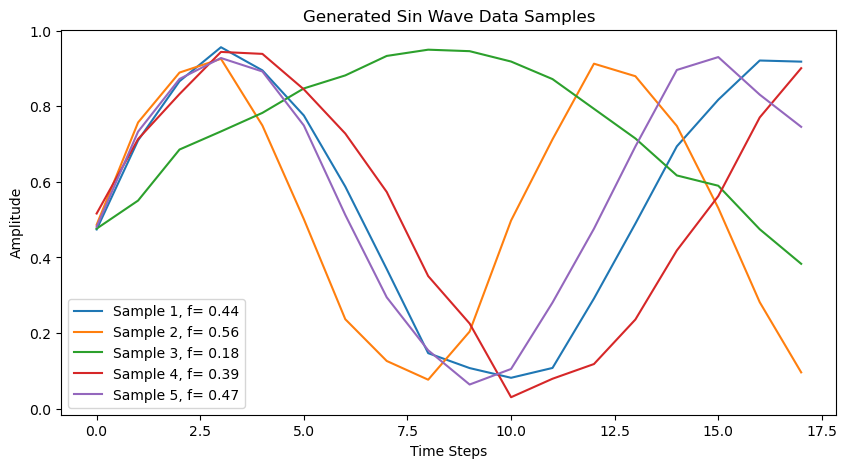

In [5]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X[i].flatten(), label=f"Sample {i+1}, f= {y_true[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [6]:
# train test split
percentage = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, test_size=1 - percentage, random_state=42
)

In [7]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 5),  # =1D kernel size
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0),
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 6.8
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_2"
)
NAHEA_CNN.eval()

Final FC NN: Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)
Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [8]:
# train the model
batch_size = 16
epochs = 20
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
print(f"{NAHEA_CNN.parameters()}")
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
    lr=0.01,
    weight_decay=1e-5,
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = [NAHEA_CNN(xx) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted.squeeze(1), y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1}/{n_samples // batch_size}, Loss: {loss.item()}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss: {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

{'positions': tensor([[-13.6000,   0.0000],
        [ -6.8000,   0.0000],
        [  0.0000,   0.0000],
        [  6.8000,   0.0000],
        [ 13.6000,   0.0000]], requires_grad=True), 'local_pulses_omega_1': tensor([0.5000, 1.0000, 1.5000, 1.0000, 0.5000], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'global_pulse_omega_1': tensor(1., requires_grad=True), 'global_pulse_delta_1': tensor(0., requires_grad=True), 'global_pulse_omega_2': tensor(0.5000, requires_grad=True), 'global_pulse_delta_2': tensor(0., requires_grad=True), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 4.1333e-02,  5.1887e-02,  3.4788e-02,  3.5756e-02,  5.1082e-02,
         5.1876e-02,  4.5204e-02,  3.6332e-02,  3.3570e-05,  3.9542e-02,
         2.4623e-02,  7.8272e-02,  5.3176e-02,  2.6129e-03,  6.3220e-02,
         3.4178e-02,  1.7685e-02,  4.4071e-02,  3.7951e-02, -1.7689e-03

Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.37609873804495997
Batch 2/13, Loss: 0.23423514125832046
Batch 3/13, Loss: 0.1456680458768163
Batch 4/13, Loss: 0.12141866087551059
Batch 5/13, Loss: 0.06207615355505149
Batch 6/13, Loss: 0.1036728883265265
Batch 7/13, Loss: 0.09946320832544042
Batch 8/13, Loss: 0.1379080835828253
Batch 9/13, Loss: 0.10321081499067002
Batch 10/13, Loss: 0.1031159966053509
Batch 11/13, Loss: 0.06036852315472032
Epoch 1 train loss: 0.1406578413269266


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.061268882089531906
Batch 2/13, Loss: 0.05362020328384169
Batch 3/13, Loss: 0.05797830468417068
Batch 4/13, Loss: 0.07786094428195138
Batch 5/13, Loss: 0.06917394330599053
Batch 6/13, Loss: 0.055414397331430304
Batch 7/13, Loss: 0.04384488565855647
Batch 8/13, Loss: 0.06582764808548154
Batch 9/13, Loss: 0.038906076573912714
Batch 10/13, Loss: 0.07772165966124196
Batch 11/13, Loss: 0.06489286212686951
Epoch 2 train loss: 0.060591800643907165


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.05679521291380198
Batch 2/13, Loss: 0.023543709820741665
Batch 3/13, Loss: 0.06442004539507294
Batch 4/13, Loss: 0.057463636754733996
Batch 5/13, Loss: 0.05509833946115911
Batch 6/13, Loss: 0.05709415711935119
Batch 7/13, Loss: 0.06864184412140797
Batch 8/13, Loss: 0.040927662501022366
Batch 9/13, Loss: 0.044121210167547616
Batch 10/13, Loss: 0.04705590297377561
Batch 11/13, Loss: 0.03841637504105766
Epoch 3 train loss: 0.0503252814790611


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.049232732579979455
Batch 2/13, Loss: 0.042418409119753996
Batch 3/13, Loss: 0.04594414302182723
Batch 4/13, Loss: 0.02924913418229769
Batch 5/13, Loss: 0.032231760264388676
Batch 6/13, Loss: 0.02646538229249696
Batch 7/13, Loss: 0.06226407486988301
Batch 8/13, Loss: 0.03935529574511056
Batch 9/13, Loss: 0.025141747017025266
Batch 10/13, Loss: 0.0255115922519031
Batch 11/13, Loss: 0.035934844592268075
Epoch 4 train loss: 0.03761355599426673


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.03537152562081568
Batch 2/13, Loss: 0.020530140323757953
Batch 3/13, Loss: 0.02646349927573905
Batch 4/13, Loss: 0.027094353617830032
Batch 5/13, Loss: 0.023790197734694464
Batch 6/13, Loss: 0.02681845926631366
Batch 7/13, Loss: 0.024539054837116984
Batch 8/13, Loss: 0.01362880649077164
Batch 9/13, Loss: 0.04229052466327883
Batch 10/13, Loss: 0.026564468446890855
Batch 11/13, Loss: 0.020693931172389497
Epoch 5 train loss: 0.026162269222690784


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.022899936932537064
Batch 2/13, Loss: 0.01705708690774945
Batch 3/13, Loss: 0.015341500900125954
Batch 4/13, Loss: 0.01757812635281162
Batch 5/13, Loss: 0.011168898192069333
Batch 6/13, Loss: 0.020747984300822725
Batch 7/13, Loss: 0.009745281756996203
Batch 8/13, Loss: 0.013029811857129309
Batch 9/13, Loss: 0.01414166611827977
Batch 10/13, Loss: 0.010582749767588783
Batch 11/13, Loss: 0.006435816834054635
Epoch 6 train loss: 0.01442989635637862


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.009686411575182373
Batch 2/13, Loss: 0.012455481372069376
Batch 3/13, Loss: 0.007209190375914139
Batch 4/13, Loss: 0.01157387681667585
Batch 5/13, Loss: 0.005822710600962922
Batch 6/13, Loss: 0.009843479712316413
Batch 7/13, Loss: 0.009007516976190183
Batch 8/13, Loss: 0.008749355741216273
Batch 9/13, Loss: 0.003456206830539887
Batch 10/13, Loss: 0.00523561602030745
Batch 11/13, Loss: 0.005588335049720759
Epoch 7 train loss: 0.008057107370099601


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.007194911158083838
Batch 2/13, Loss: 0.004291970028082261
Batch 3/13, Loss: 0.005425120458655546
Batch 4/13, Loss: 0.004472730290568573
Batch 5/13, Loss: 0.005264180411901883
Batch 6/13, Loss: 0.005723548621686343
Batch 7/13, Loss: 0.005577734457452227
Batch 8/13, Loss: 0.0036605314808004206
Batch 9/13, Loss: 0.0027854610075248023
Batch 10/13, Loss: 0.0031887439606969915
Batch 11/13, Loss: 0.006144773722787739
Epoch 8 train loss: 0.004884518690749148


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.002489318825731898
Batch 2/13, Loss: 0.004610271506227801
Batch 3/13, Loss: 0.002385684499656083
Batch 4/13, Loss: 0.0039367136606424415
Batch 5/13, Loss: 0.001704890730665925
Batch 6/13, Loss: 0.0031582989956886504
Batch 7/13, Loss: 0.002938300674525174
Batch 8/13, Loss: 0.005148423892785166
Batch 9/13, Loss: 0.0024165177016650828
Batch 10/13, Loss: 0.002982067254251941
Batch 11/13, Loss: 0.0027970966755815844
Epoch 9 train loss: 0.003142507674311068


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.002537866403690088
Batch 2/13, Loss: 0.0013082835303102973
Batch 3/13, Loss: 0.0019558821041559976
Batch 4/13, Loss: 0.0016974833712213302
Batch 5/13, Loss: 0.0023991692210239618
Batch 6/13, Loss: 0.0013051802736203204
Batch 7/13, Loss: 0.0011916418433775646
Batch 8/13, Loss: 0.0011542281376576754
Batch 9/13, Loss: 0.001438331088990903
Batch 10/13, Loss: 0.0012234978155318795
Batch 11/13, Loss: 0.0010378650221352346
Epoch 10 train loss: 0.0015681298919741138


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0009199870095334675
Batch 2/13, Loss: 0.0004995026521870898
Batch 3/13, Loss: 0.0007871268272745865
Batch 4/13, Loss: 0.0008788219719252177
Batch 5/13, Loss: 0.0007937296196683678
Batch 6/13, Loss: 0.0007270584072406631
Batch 7/13, Loss: 0.0006791023424212732
Batch 8/13, Loss: 0.0002726196204977312
Batch 9/13, Loss: 0.0004924939918163994
Batch 10/13, Loss: 0.0008629079494817865
Batch 11/13, Loss: 0.0006765323324714537
Epoch 11 train loss: 0.0006899893385925488


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0004750022497474848
Batch 2/13, Loss: 0.00038960510018530114
Batch 3/13, Loss: 0.00037119432624949133
Batch 4/13, Loss: 0.0005680041325914857
Batch 5/13, Loss: 0.0006486922793947397
Batch 6/13, Loss: 0.0006433357453775584
Batch 7/13, Loss: 0.0002670918717303946
Batch 8/13, Loss: 0.0004304225194452986
Batch 9/13, Loss: 0.0007984447674057022
Batch 10/13, Loss: 0.0010079772414733593
Batch 11/13, Loss: 0.0005100743805537627
Epoch 12 train loss: 0.0005554404194685981


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0004231673582489996
Batch 2/13, Loss: 0.0005052300983031541
Batch 3/13, Loss: 0.0005262793459114785
Batch 4/13, Loss: 0.00032934666829850676
Batch 5/13, Loss: 0.0004306141990132247
Batch 6/13, Loss: 0.0004950739864402882
Batch 7/13, Loss: 0.00027597618240602484
Batch 8/13, Loss: 0.0004046052755380288
Batch 9/13, Loss: 0.0004496059504022434
Batch 10/13, Loss: 0.000281324924011387
Batch 11/13, Loss: 0.0006314758169084217
Epoch 13 train loss: 0.0004320636186801598


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0003395974378348299
Batch 2/13, Loss: 0.00045822563076918226
Batch 3/13, Loss: 0.00018676381474488774
Batch 4/13, Loss: 0.0003175030493794789
Batch 5/13, Loss: 0.00040923676555591624
Batch 6/13, Loss: 0.00027275474326679387
Batch 7/13, Loss: 0.0003349043144620985
Batch 8/13, Loss: 0.00023589854759119744
Batch 9/13, Loss: 0.00026825455758980516
Batch 10/13, Loss: 0.0003089950905810101
Batch 11/13, Loss: 0.0004374651189158837
Epoch 14 train loss: 0.0003245090064264622


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.00028631781687708276
Batch 2/13, Loss: 0.00024353636318856267
Batch 3/13, Loss: 0.0003125710688456129
Batch 4/13, Loss: 0.0003363561329717069
Batch 5/13, Loss: 0.0001965331453039931
Batch 6/13, Loss: 0.0003763787303008541
Batch 7/13, Loss: 0.00041212050828784126
Batch 8/13, Loss: 0.00023850222822615003
Batch 9/13, Loss: 0.00022289245613594448
Batch 10/13, Loss: 0.0004107575168834902
Batch 11/13, Loss: 9.579619829090499e-05
Epoch 15 train loss: 0.0002847056513920131


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.00016150389124765173
Batch 2/13, Loss: 0.0003336684849296255
Batch 3/13, Loss: 0.00027515833494173267
Batch 4/13, Loss: 0.0003494787468079727
Batch 5/13, Loss: 0.00038432164490452087
Batch 6/13, Loss: 0.00010807436967239783
Batch 7/13, Loss: 0.0002605991399770622
Batch 8/13, Loss: 0.00018658652171239538
Batch 9/13, Loss: 0.0001818397406989957
Batch 10/13, Loss: 0.00032619490386411097
Batch 11/13, Loss: 0.00033729532223550384
Epoch 16 train loss: 0.0002640655546356336


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0003824555787559509
Batch 2/13, Loss: 0.00030830999698684404
Batch 3/13, Loss: 0.00014586605179115175
Batch 4/13, Loss: 0.00017024061827746243
Batch 5/13, Loss: 0.00023537311838301095
Batch 6/13, Loss: 0.00019686657365564428
Batch 7/13, Loss: 0.0001723588386672453
Batch 8/13, Loss: 0.00040416274553520357
Batch 9/13, Loss: 0.000373793585094292
Batch 10/13, Loss: 0.0001560666562367442
Batch 11/13, Loss: 0.0001965938281104647
Epoch 17 train loss: 0.0002492806901358195


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.00010616722366582661
Batch 2/13, Loss: 0.0003214606459249525
Batch 3/13, Loss: 0.00041590057942601734
Batch 4/13, Loss: 0.00014593539555014164
Batch 5/13, Loss: 0.0003418863204210869
Batch 6/13, Loss: 0.00011728927844466589
Batch 7/13, Loss: 0.00029089564262729426
Batch 8/13, Loss: 0.00024954222325134146
Batch 9/13, Loss: 0.0004631261121355981
Batch 10/13, Loss: 0.00017492784319799766
Batch 11/13, Loss: 0.0002188239781214325
Epoch 18 train loss: 0.0002587232038878504


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0001751850781270373
Batch 2/13, Loss: 0.00012949804960977378
Batch 3/13, Loss: 0.00044302205266895037
Batch 4/13, Loss: 0.00018640988646209046
Batch 5/13, Loss: 0.0001928670841773245
Batch 6/13, Loss: 0.00036966696344105555
Batch 7/13, Loss: 0.000480680993389461
Batch 8/13, Loss: 0.0002038123581512193
Batch 9/13, Loss: 0.0005857033383642572
Batch 10/13, Loss: 0.00033272983342899463
Batch 11/13, Loss: 0.00019731348696110546
Epoch 19 train loss: 0.00029971719316193357


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.00023243580608012742
Batch 2/13, Loss: 0.0002892999590655108
Batch 3/13, Loss: 0.00019232545365137222
Batch 4/13, Loss: 0.0001865480032520527
Batch 5/13, Loss: 0.00020836927379057463
Batch 6/13, Loss: 0.00019219635279186327
Batch 7/13, Loss: 0.00026894001313198504
Batch 8/13, Loss: 0.00021223010843417336
Batch 9/13, Loss: 0.0002109770824402271
Batch 10/13, Loss: 0.0003018646091797162
Batch 11/13, Loss: 0.0004355844952257297
Epoch 20 train loss: 0.00024825192336757566
Final loss: 0.0004355844952257297
Final loss (RMSE): 0.020870661111371862


In [9]:
# test the model
NAHEA_CNN.eval()
y_pred_test = []
for i in range(len(X_test)):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].item()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

Test loss MSE: 0.0002836992048620172
RMSE: 0.016843372728228074
final parameters:
{'positions': tensor([[-13.6665,   0.0000],
        [ -6.8045,   0.0000],
        [ -0.0409,   0.0000],
        [  6.9148,   0.0000],
        [ 13.5408,   0.0000]], requires_grad=True), 'local_pulses_omega_1': tensor([0.3444, 1.1507, 1.3128, 1.3060, 0.5466], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'global_pulse_omega_1': tensor(0.8755, requires_grad=True), 'global_pulse_delta_1': tensor(0., requires_grad=True), 'global_pulse_omega_2': tensor(0.5597, requires_grad=True), 'global_pulse_delta_2': tensor(0., requires_grad=True), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.1286,  0.1488,  0.2504, -0.0494,  0.0652,  0.0938, -0.0106, -0.0344,
         0.2280,  0.2381, -0.1737, -0.1389, -0.0395,  0.2944,  0.0531,  0.2691,
         0.0022,  0.0429,  0.0765,  0.1053, 

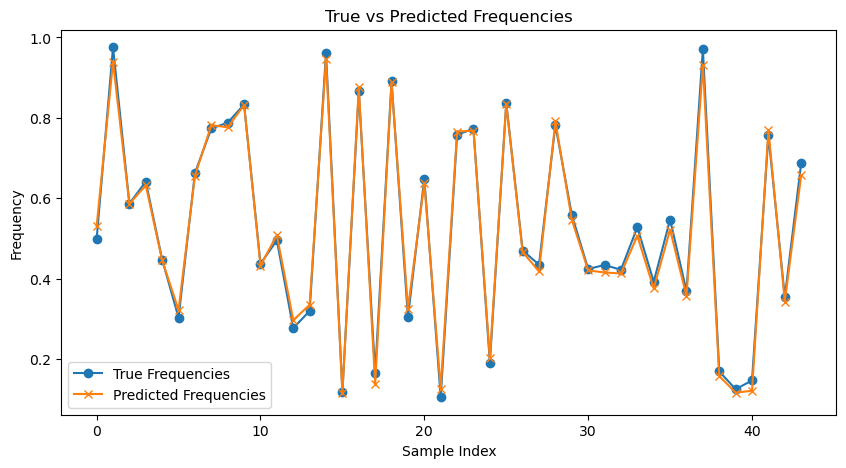

In [10]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="True Frequencies", marker='o')
plt.plot(y_pred_test.numpy(), label="Predicted Frequencies", marker='x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

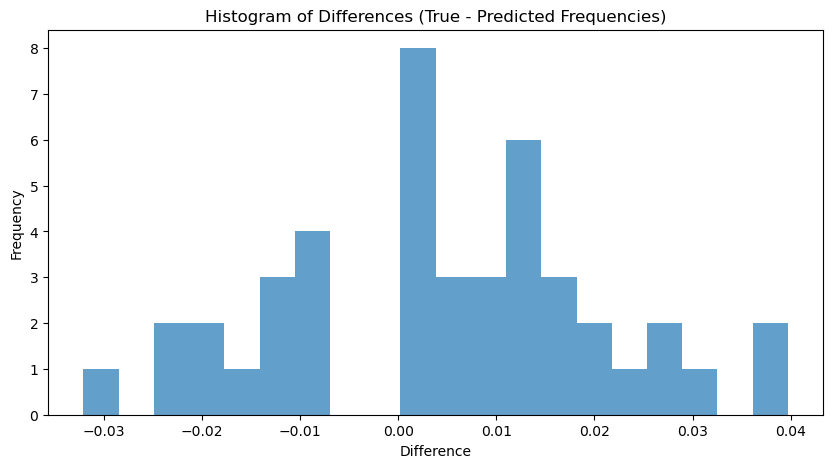

In [11]:
diffs = y_test - y_pred_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(diffs.numpy(), bins=20, alpha=0.7)
plt.title("Histogram of Differences (True - Predicted Frequencies)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show() 

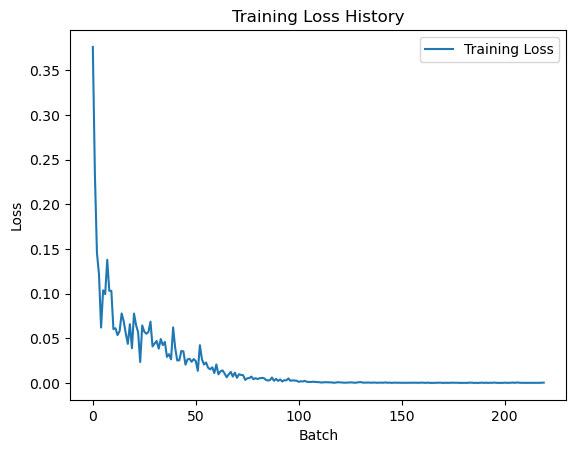

In [12]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [13]:
params_hist[0].keys()

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])

In [16]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta_1"].detach().numpy() for i in params_hist])

In [17]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


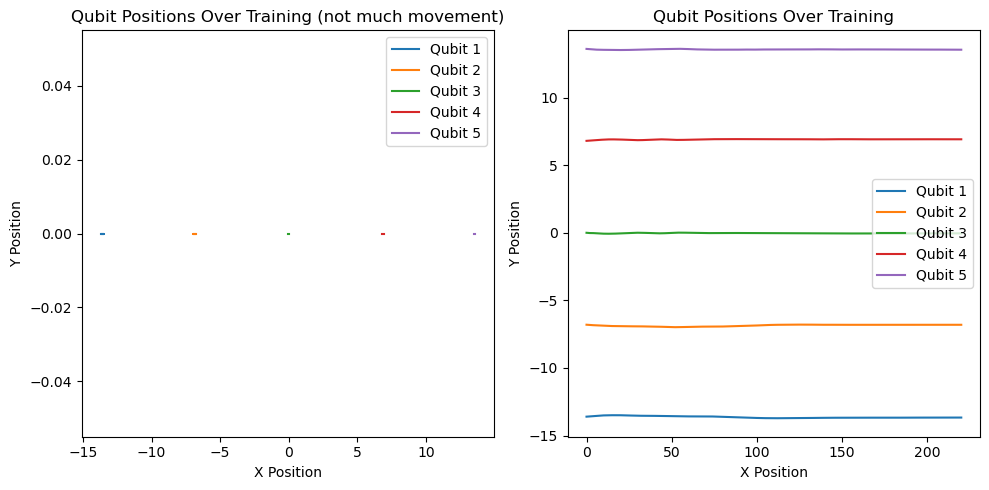

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (not much movement)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], label="Qubit 1")
plt.plot(positions_hist[:, 1, 0], label="Qubit 2")
plt.plot(positions_hist[:, 2, 0], label="Qubit 3")
plt.plot(positions_hist[:, 3, 0], label="Qubit 4")
plt.plot(positions_hist[:, 4, 0], label="Qubit 5")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

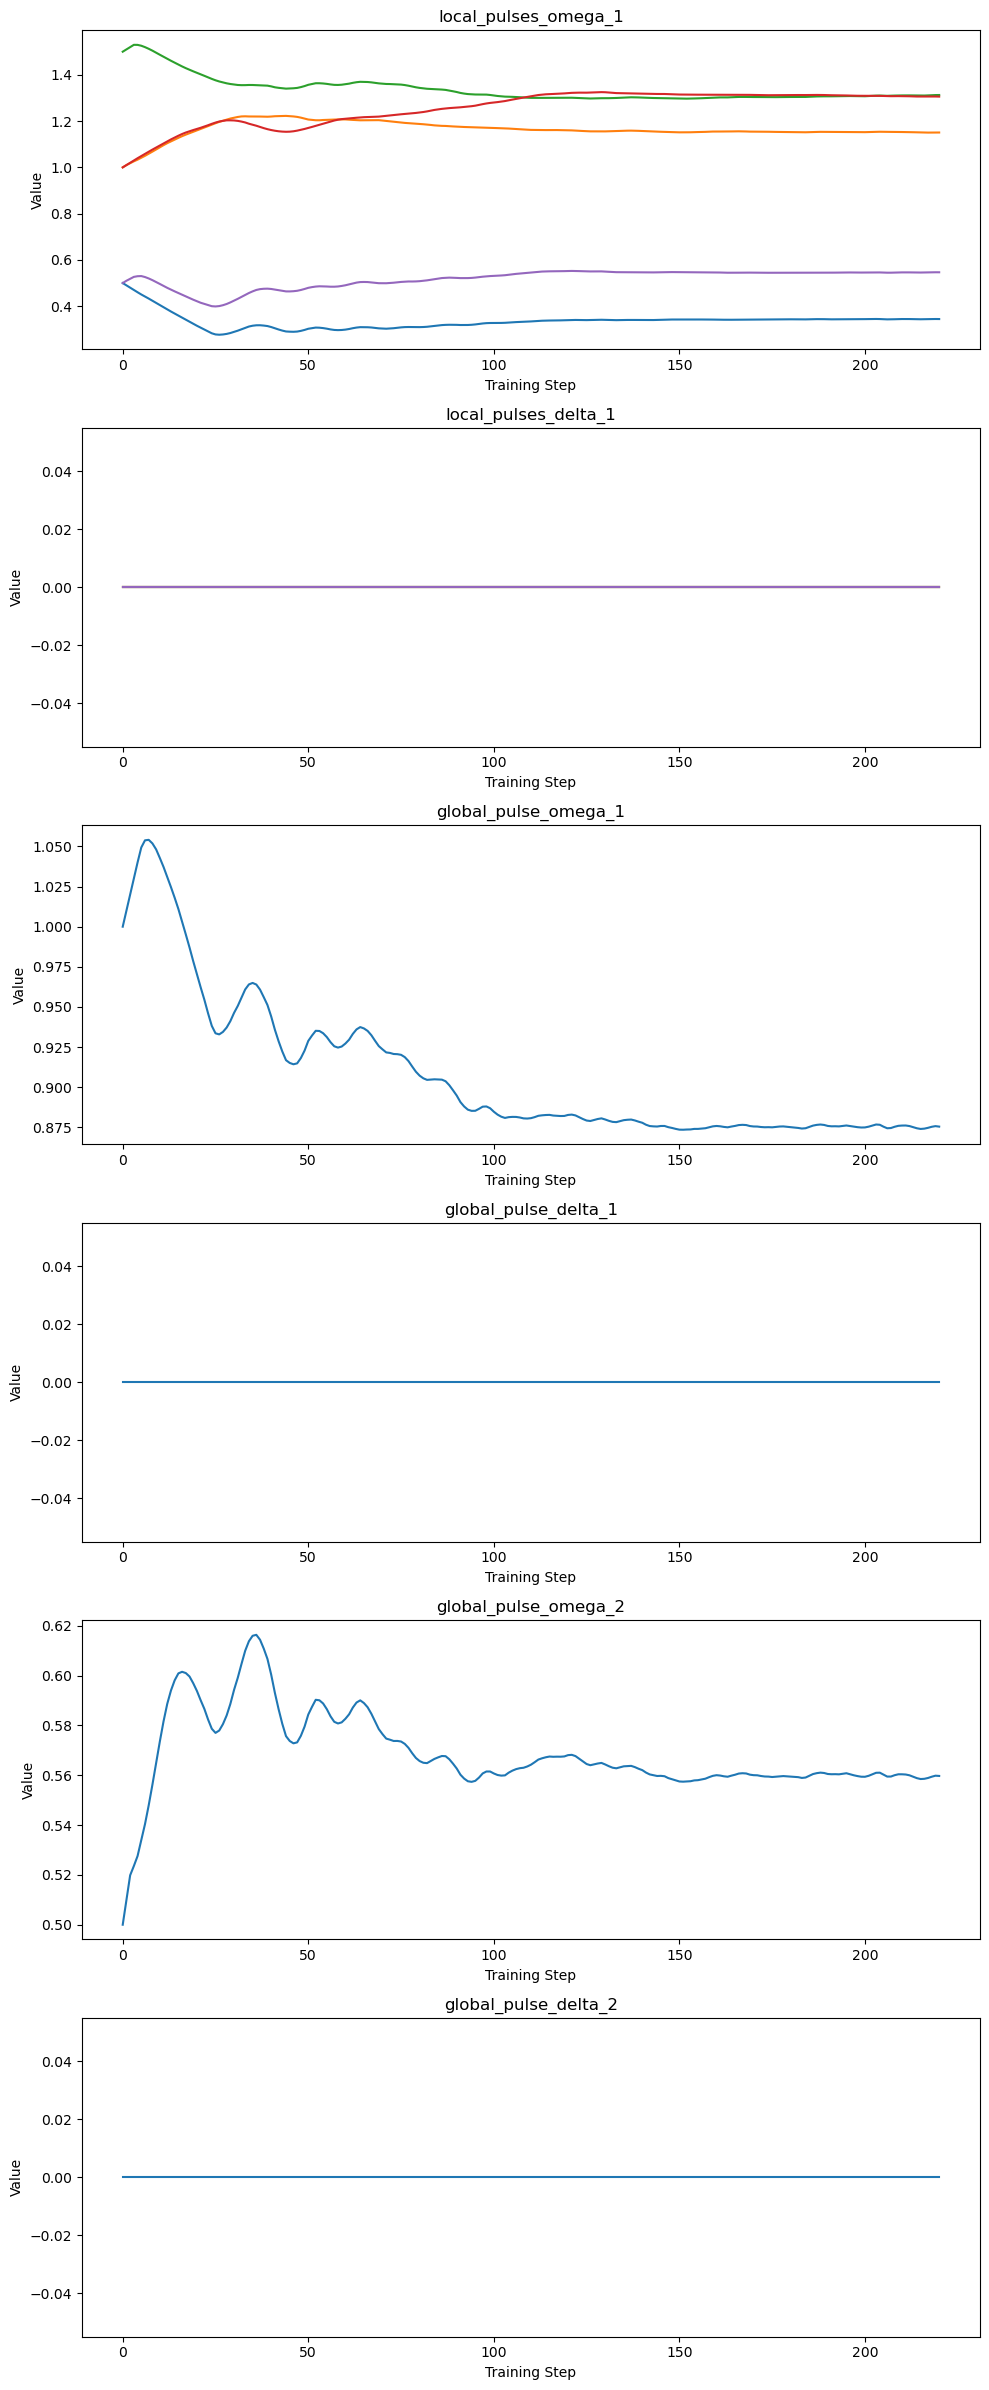

In [22]:
plot_keys = ['local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  

In [25]:
params_hist_nice.keys()

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])

In [41]:
params_hist_nice['conv_params'].shape # 2**5

(221, 32)

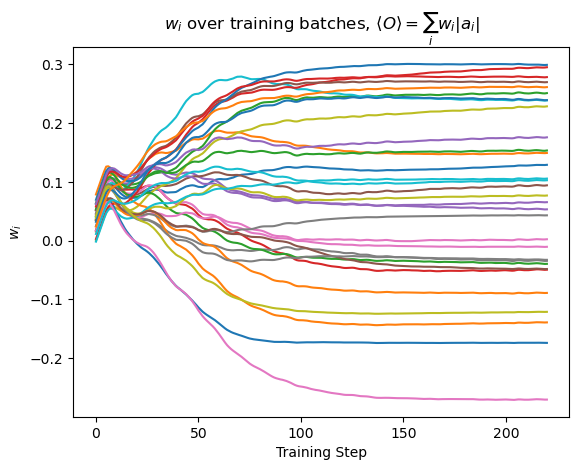

In [46]:
conv_params = params_hist_nice['conv_params']
for i_conv_param in range(len(conv_params[0])):
    plt.plot(conv_params[:, i_conv_param], label=f"Conv Param {i_conv_param}")
plt.xlabel("Training Step")
plt.ylabel("$w_i$")
plt.title(r"$w_i$ over training batches, $\langle O \rangle = \sum_i w_i |a_i|$")
# plt.legend()
plt.show()

In [45]:
import pickle

# number of learned parameters, i.e. with require_grad=True
NAHEA_CNN.train()
# number of parameters
n_params = sum(v.numel() for p, v in NAHEA_CNN.parameters().items() if v.requires_grad)
print(f"Number of trainable parameters: {n_params}")
# save training history
with open("losses_hist/NAHEA_CNN2_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            loss_test.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

Number of trainable parameters: 177
